In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization



# Parameters
I1 = 1.0  # Moment of inertia of the first link
I2 = 1.0  # Moment of inertia of the second link
damping1 = 0.1  # Damping coefficient for the first joint
damping2 = 0.1  # Damping coefficient for the second joint
L1 = 1.0  # Length of the first link
L2 = 1.0  # Length of the second link
dt = 0.1  # Time step

# Initialize state vector: 101 rows (time steps) and 4 columns (state variables)
x = np.zeros((101, 4))

# Initial conditions
x[0, 0] = 1.0  # Initial angle theta1
x[0, 1] = 1.0  # Initial angle theta2

# Control inputs (torques)
u1 = 1.0  # Predefined control input for joint 1
u2 = 0.5  # Predefined control input for joint 2

# State-space function f(x, u)
def f(x, u1, u2):
    theta1_dot = x[2]
    theta2_dot = x[3]
    theta1_ddot = (u1 - damping1 * x[2]) / I1
    theta2_ddot = (u2 - damping2 * x[3]) / I2
    return np.array([theta1_dot, theta2_dot, theta1_ddot, theta2_ddot])

# Output function y(x)
def y(x):
    theta1 = x[0]
    theta2 = x[1]
    y1 = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)  # Horizontal position of end effector
    y2 = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)  # Vertical position of end effector
    return np.array([y1, y2])

# Initialize output vector: 101 rows (time steps) and 2 columns (output variables)
y_values = np.zeros((101, 2))

# Simulate the system for 100 time steps
for k in range(100):
    # Update the state vector for the next time step
    x[k+1, :] = x[k, :] + dt * f(x[k, :], u1, u2)
    
    # Calculate and store the output for the current time step
    y_values[k, :] = y(x[k, :])



In [109]:

RNN_input = x.reshape(-1, 1, 4)

RNN_input = RNN_input.repeat(10, axis=1) 



In [110]:
y_output = y_values.reshape(-1, 1, 2)
RNN_output = y_output
RNN_output = RNN_output.repeat(10, axis=1)

RNN_output.shape

(101, 10, 2)

In [111]:
scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

RNN_input = scaler_X.transform(RNN_input.reshape(-1, 4)).reshape(-1,10,4)
RNN_output = scaler_y.transform(RNN_output.reshape(-1, 2)).reshape(-1,10,2)

X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

y_train.shape

(70, 10, 2)

Epoch 1/100
1/1 - 4s - loss: 2.7308 - val_loss: 0.8880 - 4s/epoch - 4s/step
Epoch 2/100
1/1 - 0s - loss: 1.8446 - val_loss: 0.8778 - 41ms/epoch - 41ms/step
Epoch 3/100
1/1 - 0s - loss: 1.5860 - val_loss: 0.8770 - 41ms/epoch - 41ms/step
Epoch 4/100
1/1 - 0s - loss: 1.3101 - val_loss: 0.8818 - 43ms/epoch - 43ms/step
Epoch 5/100
1/1 - 0s - loss: 1.1844 - val_loss: 0.8905 - 42ms/epoch - 42ms/step
Epoch 6/100
1/1 - 0s - loss: 1.1575 - val_loss: 0.9000 - 45ms/epoch - 45ms/step
Epoch 7/100
1/1 - 0s - loss: 1.1162 - val_loss: 0.9094 - 44ms/epoch - 44ms/step
Epoch 8/100
1/1 - 0s - loss: 1.0770 - val_loss: 0.9171 - 43ms/epoch - 43ms/step
Epoch 9/100
1/1 - 0s - loss: 1.0823 - val_loss: 0.9219 - 42ms/epoch - 42ms/step
Epoch 10/100
1/1 - 0s - loss: 1.0606 - val_loss: 0.9239 - 43ms/epoch - 43ms/step
Epoch 11/100
1/1 - 0s - loss: 1.0962 - val_loss: 0.9227 - 41ms/epoch - 41ms/step
Epoch 12/100
1/1 - 0s - loss: 1.0509 - val_loss: 0.9197 - 46ms/epoch - 46ms/step
Epoch 13/100
1/1 - 0s - loss: 1.0266 - va

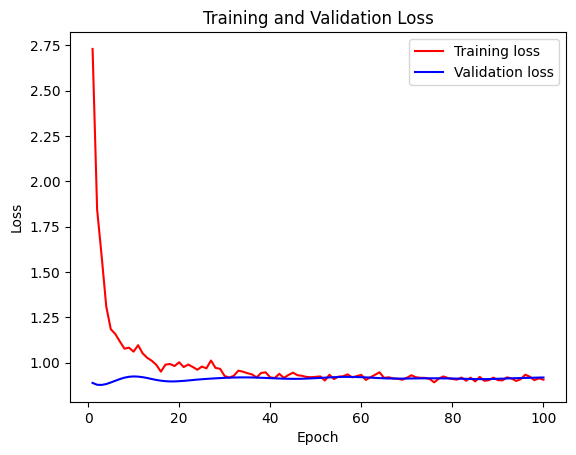

In [113]:
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.2))  # Dropout with 20% rate
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(2, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.1, verbose=2)

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()